# Swish-based classifier using cosine-annealed LR with restarts and data augmentation
- Swish activation, 4 layers, 100 neurons per layer
- LR using cosine-annealing with restarts and cycle multiplicity of 2
- Data is augmentaed via phi rotations, and transvers and longitudinal flips
- Validation score use ensemble of 10 models weighted by loss

### Import modules

In [ ]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from __future__ import division
import sys
import os
sys.path.append('../')
from modules.basics import *
from modules.class_basics import *
from modules.data_import import *

## Options

In [2]:
with open(DATA_PATH/'feats.pkl', 'rb') as fin:
    train_feats = pickle.load(fin)

In [12]:
n_models = 10
patience = 2
max_epochs = 200

ensemble_size = 10
ensemble_mode = 'loss'

compile_args = {'loss':'binary_crossentropy', 'optimizer':'adam'}
train_params = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
model_params = {'version':'modelSwish', 'n_in':len(train_feats), 'compile_args':compile_args, 'mode':'classifier'}

print ("\nTraining on", len(train_feats), "features:", [var for var in train_feats])


Training on 30 features: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']


## Import data

In [13]:
with open(DATA_PATH/'input_pipe.pkl', 'rb') as fin:
    input_pipe = pickle.load(fin)

In [14]:
train_fy = FoldYielder(h5py.File(DATA_PATH/'train.hdf5', "r+"))

def reconvert_event(in_data):
    move_to_cartesian(in_data, 'PRI_tau', drop=False)
    move_to_cartesian(in_data, 'PRI_lep', drop=False)
    move_to_cartesian(in_data, 'PRI_jet_leading', drop=False)
    move_to_cartesian(in_data, 'PRI_jet_subleading', drop=False)
    move_to_cartesian(in_data, 'PRI_met', z=False)

id = 19
nom = pd.DataFrame(train_fy.get_fold(0)['inputs'], columns=train_feats)[id:id+1]

z_flip = nom.copy()
z_flip_event(z_flip)
reconvert_event(z_flip)

rot = nom.copy()
rotate_event(rot)
reconvert_event(rot)

rot_y = nom.copy()
rotate_event(rot_y)
y_flip_event(rot_y)
reconvert_event(rot_y)

rot_yz = nom.copy()
rotate_event(rot_yz)
y_flip_event(rot_yz)
z_flip_event(rot_yz)
reconvert_event(rot_yz)

comp_events([nom, rot, rot_y, rot_yz])

/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


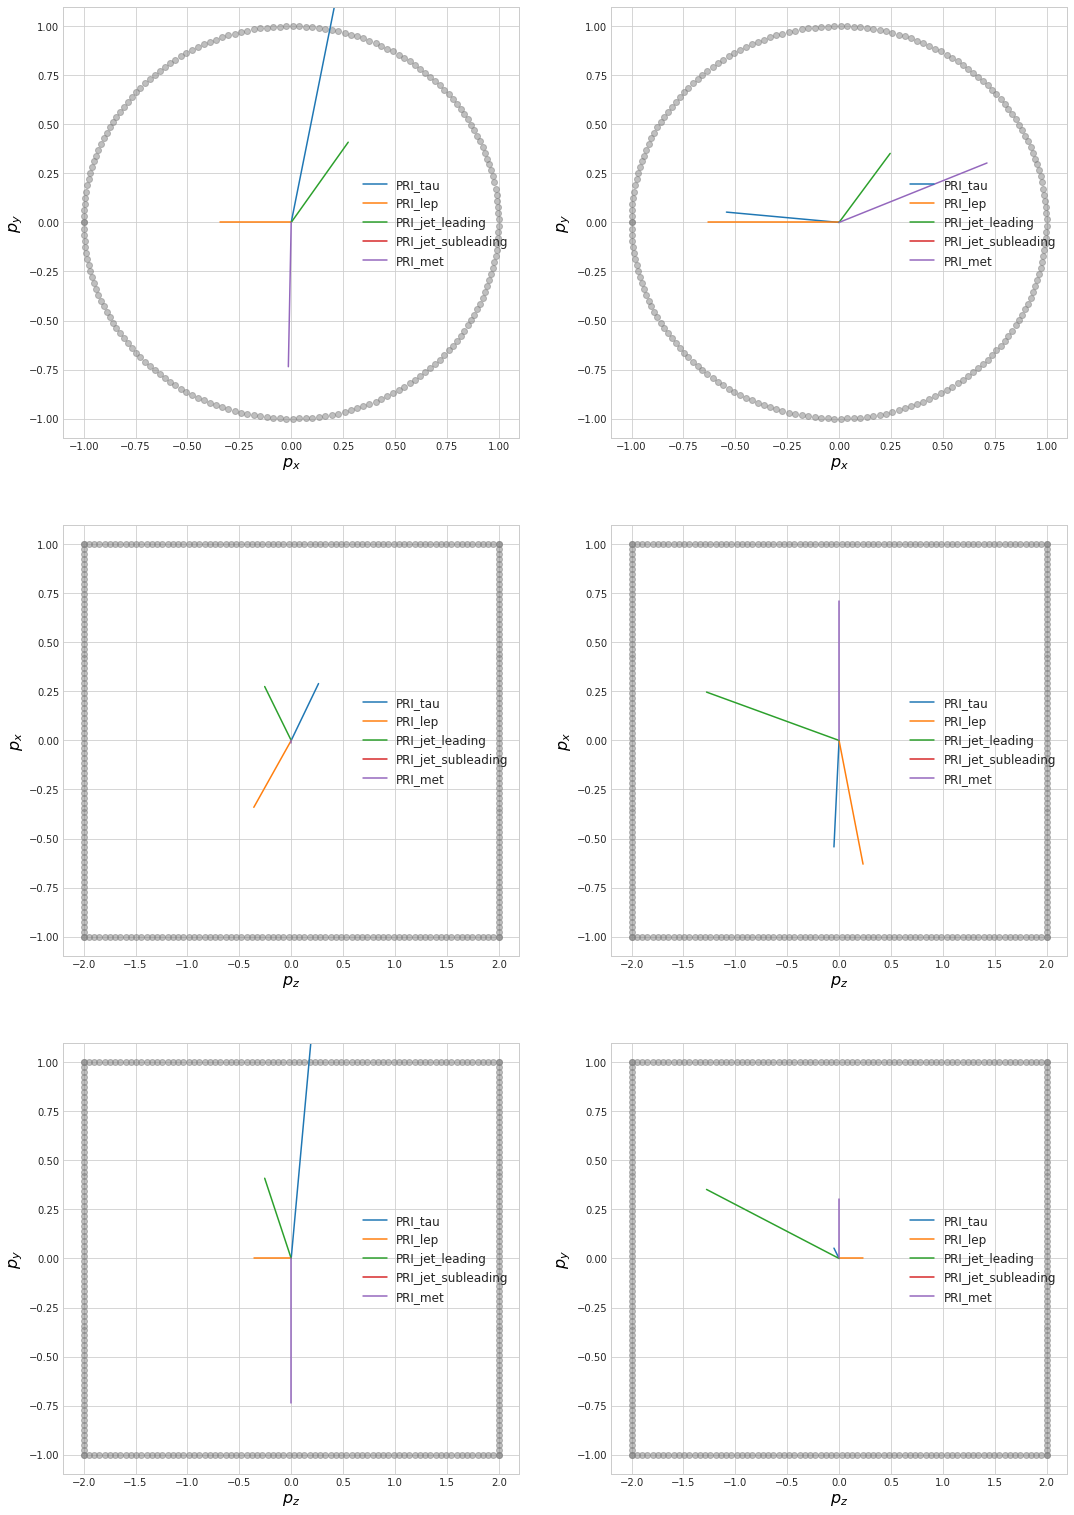

In [15]:
id = 0
pd.DataFrame(train_fy.get_fold(0)['inputs'], columns=train_feats)[id:id+1]
comp_events([pd.DataFrame(train_fy.get_fold(0)['inputs'], columns=train_feats)[id:id+1],
             pd.DataFrame(train_fy.get_fold(0)['inputs'], columns=train_feats)[id+1:id+2]])

## Determine LR

2 classes found, running in binary mode



/home/giles/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
No handles with labels found to put in legend.



______________________________________
Training finished
Cross-validation took 31.044s 


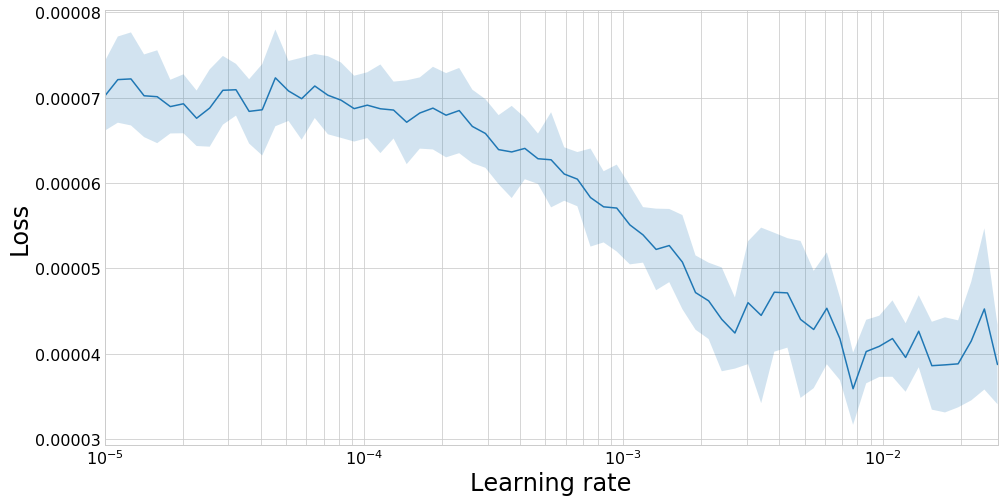

______________________________________



In [16]:
lr_finder = fold_lr_find(train_fy, get_model, model_params, train_params,
                         lr_bounds=[1e-5,1e-1], train_on_weights=True, verbose=0)

## Train classifier

In [17]:
model_gen_params = {**model_params, 'compile_args':{**compile_args, 'lr':8e-4}}
use_callbacks = {'CosAnnealLR':{'cycle_mult':2, 'reverse':False, 'redux_decay':True}}
ams_args = {'n_total':250000, 'br':10, 'delta_b':0}
plots = ['history', 'lr']

In [18]:
model_gen_params

{'version': 'modelSwish',
 'n_in': 30,
 'compile_args': {'loss': 'binary_crossentropy',
  'optimizer': 'adam',
  'lr': 0.0008,
  'amsgrad': False,
  'beta_1': 0.9},
 'mode': 'classifier'}

Training using weights
Training model 1 / 10
Using cosine LR annealing
2 classes found, running in binary mode



/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.753696). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.377309). Check your callbacks.
  % delta_t_median)


1 New best found: 4.107902663058948e-05
2 New best found: 3.712982076030297e-05
3 New best found: 3.631035966580333e-05
4 New best found: 3.522591889407417e-05
5 New best found: 3.4695518422634566e-05
6 New best found: 3.422024922252033e-05
7 New best found: 3.411659815948831e-05
8 New best found: 3.405869626236302e-05
9 New best found: 3.363761903445622e-05
10 New best found: 3.3472015345147855e-05
11 New best found: 3.326930943054813e-05
12 New best found: 3.299257854886856e-05
13 New best found: 3.2903496873818436e-05
14 New best found: 3.282999788980102e-05
18 New best found: 3.282056767446843e-05
19 New best found: 3.275593985103194e-05
20 New best found: 3.249819354991661e-05
21 New best found: 3.2459348142275535e-05
22 New best found: 3.234691684925742e-05
24 New best found: 3.230434933748657e-05
25 New best found: 3.227006518237274e-05
26 New best found: 3.225434521628249e-05
27 New best found: 3.221892439979771e-05
28 New best found: 3.216740768975897e-05
29 New best found: 3.

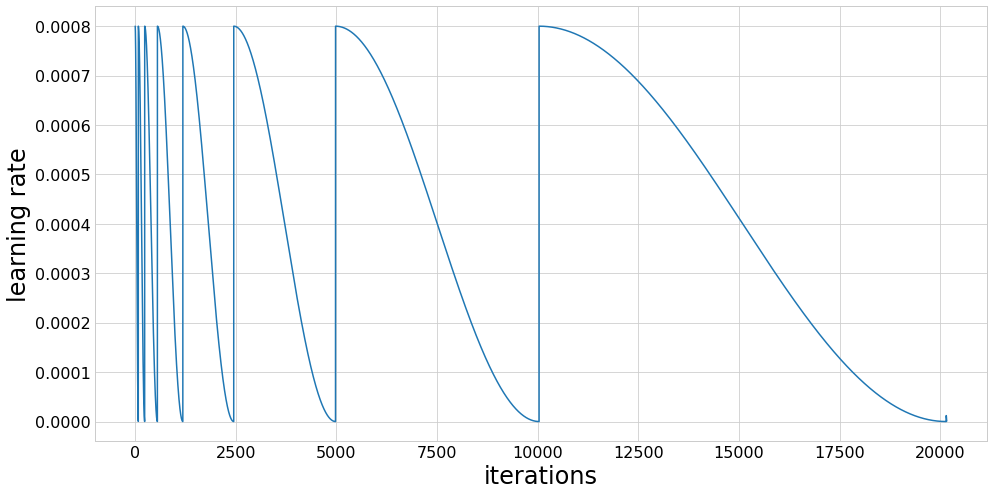

Fold took 334.090s

Training model 2 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.767432). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.384306). Check your callbacks.
  % delta_t_median)


1 New best found: 4.143593093613163e-05
2 New best found: 3.695332782372134e-05
3 New best found: 3.638477921776939e-05
4 New best found: 3.5590471758769124e-05
5 New best found: 3.452227890811628e-05
6 New best found: 3.4306852261943276e-05
7 New best found: 3.425325885327766e-05
8 New best found: 3.4215050577768126e-05
9 New best found: 3.38174925702333e-05
10 New best found: 3.344788925023749e-05
12 New best found: 3.3198261041252406e-05
13 New best found: 3.306981218920555e-05
14 New best found: 3.300601257942617e-05
15 New best found: 3.297019954843563e-05
19 New best found: 3.277324578157277e-05
23 New best found: 3.2467615130008195e-05
28 New best found: 3.2415222577401436e-05
29 New best found: 3.240468554358813e-05
30 New best found: 3.2398921610729305e-05
31 New best found: 3.2398431171895934e-05
41 New best found: 3.236030654516071e-05
43 New best found: 3.2356335516669786e-05
46 New best found: 3.227900003403192e-05
49 New best found: 3.226223721649148e-05
50 New best found

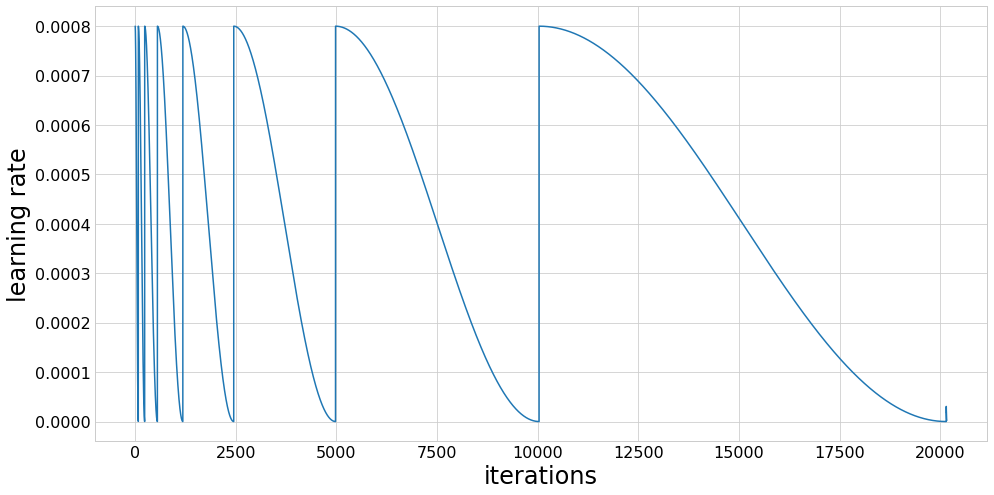

Fold took 335.165s

Training model 3 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.820251). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.410765). Check your callbacks.
  % delta_t_median)


1 New best found: 4.136316770701089e-05
2 New best found: 3.673687161037816e-05
3 New best found: 3.640011466526053e-05
4 New best found: 3.537816502053786e-05
5 New best found: 3.482445016471106e-05
6 New best found: 3.4520042990213414e-05
7 New best found: 3.449765414594074e-05
8 New best found: 3.4200052632261774e-05
9 New best found: 3.4059413151417395e-05
10 New best found: 3.3808658301681035e-05
11 New best found: 3.351308340366427e-05
12 New best found: 3.330230870384859e-05
13 New best found: 3.321062950916207e-05
14 New best found: 3.3137706387447415e-05
15 New best found: 3.313081983748593e-05
20 New best found: 3.311113013598545e-05
21 New best found: 3.299749173261955e-05
22 New best found: 3.2875249868425436e-05
24 New best found: 3.278016257202542e-05
25 New best found: 3.274709912171783e-05
26 New best found: 3.260985820501098e-05
27 New best found: 3.26068953380368e-05
28 New best found: 3.2598362876432064e-05
30 New best found: 3.25897183541985e-05
31 New best found: 3

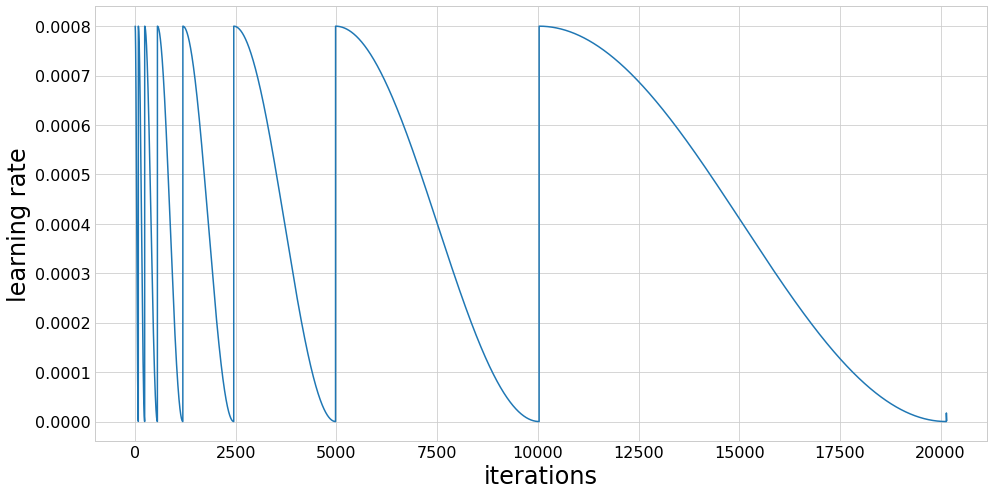

Fold took 337.866s

Training model 4 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.870592). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.435825). Check your callbacks.
  % delta_t_median)


1 New best found: 4.1906415625237895e-05
2 New best found: 3.6557162457174865e-05
3 New best found: 3.591990655426912e-05
4 New best found: 3.517114582563397e-05
5 New best found: 3.428585463197287e-05
6 New best found: 3.38111567315525e-05
7 New best found: 3.372520372857474e-05
8 New best found: 3.352526249636589e-05
9 New best found: 3.322144459655762e-05
10 New best found: 3.2913845516116446e-05
12 New best found: 3.267728790670015e-05
13 New best found: 3.264479435388141e-05
14 New best found: 3.259925992039549e-05
15 New best found: 3.2577161119545545e-05
19 New best found: 3.2537386098663454e-05
21 New best found: 3.240733993512022e-05
22 New best found: 3.231610782405901e-05
24 New best found: 3.2220756073364025e-05
26 New best found: 3.22134424790682e-05
28 New best found: 3.2119479366294464e-05
29 New best found: 3.208755420905435e-05
42 New best found: 3.206956311840014e-05
46 New best found: 3.196642271975537e-05
49 New best found: 3.190560214782421e-05
51 New best found: 3

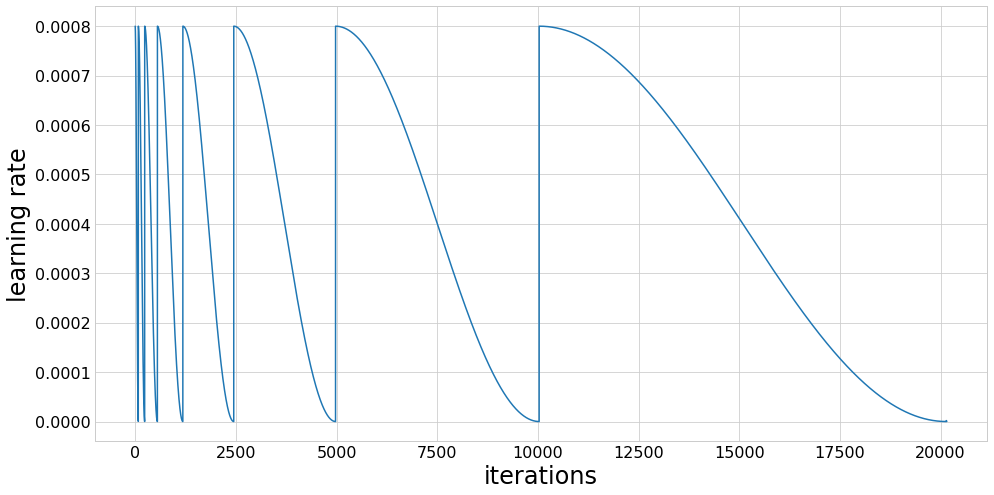

Fold took 343.036s

Training model 5 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.869775). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.435499). Check your callbacks.
  % delta_t_median)


1 New best found: 4.057109351974411e-05
2 New best found: 3.6564561721580624e-05
3 New best found: 3.5917014638733675e-05
4 New best found: 3.5002841511902825e-05
5 New best found: 3.4397698852951294e-05
6 New best found: 3.3894593312062835e-05
7 New best found: 3.381475659118394e-05
9 New best found: 3.335250775571272e-05
10 New best found: 3.32055844128186e-05
11 New best found: 3.2937707233573036e-05
12 New best found: 3.281568857168358e-05
13 New best found: 3.268681797433429e-05
15 New best found: 3.2680391711360836e-05
16 New best found: 3.2595902090435346e-05
20 New best found: 3.2579688344769036e-05
21 New best found: 3.251290462045822e-05
22 New best found: 3.24025036839171e-05
24 New best found: 3.218957705074624e-05
25 New best found: 3.211460171237358e-05
27 New best found: 3.209679465453805e-05
28 New best found: 3.202646338345918e-05
44 New best found: 3.1983503315596295e-05
46 New best found: 3.194913036721409e-05
49 New best found: 3.194024001789814e-05
50 New best foun

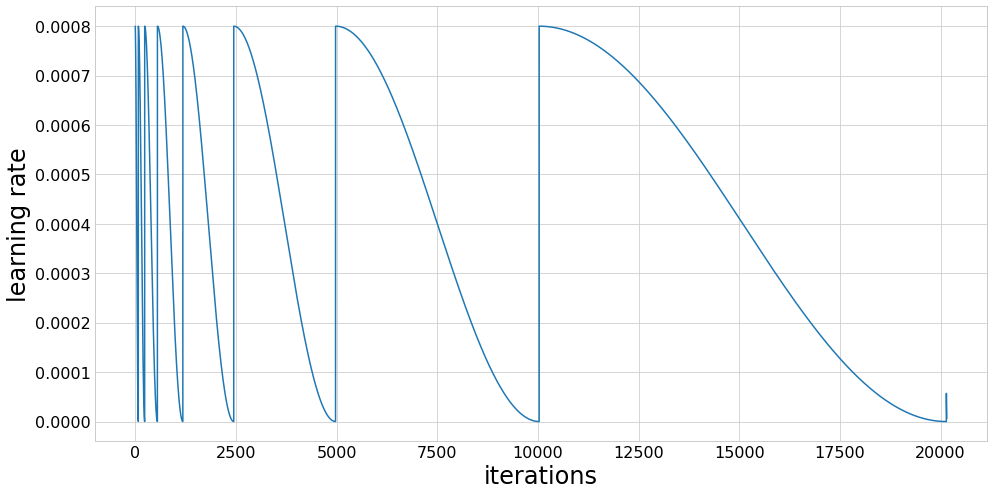

Fold took 342.527s

Training model 6 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.893966). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.447482). Check your callbacks.
  % delta_t_median)


1 New best found: 4.088294938410399e-05
2 New best found: 3.654036199732218e-05
3 New best found: 3.5965564359503336e-05
4 New best found: 3.493389015493449e-05
5 New best found: 3.434794363274704e-05
6 New best found: 3.415903775021434e-05
7 New best found: 3.397204692737432e-05
8 New best found: 3.394718555209693e-05
9 New best found: 3.348219629260712e-05
10 New best found: 3.316879056947073e-05
11 New best found: 3.298394065204775e-05
12 New best found: 3.294216019130545e-05
13 New best found: 3.278965012432309e-05
14 New best found: 3.260013957187766e-05
15 New best found: 3.259619288146496e-05
19 New best found: 3.239872694248334e-05
20 New best found: 3.220696345670149e-05
25 New best found: 3.209434655000223e-05
26 New best found: 3.207166249776492e-05
27 New best found: 3.20445670717163e-05
28 New best found: 3.198529866203899e-05
29 New best found: 3.195014425582485e-05
40 New best found: 3.191401946241967e-05
46 New best found: 3.182898278464563e-05
50 New best found: 3.1797

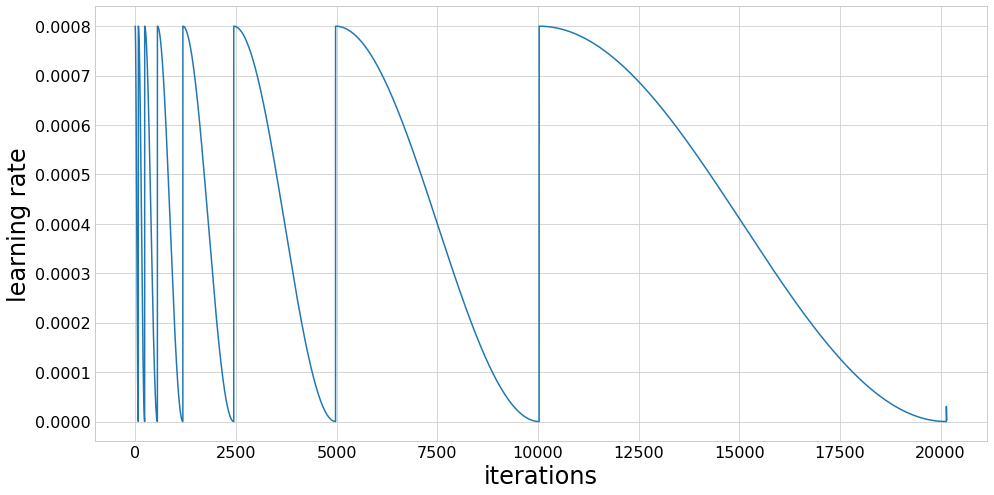

Fold took 343.862s

Training model 7 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.921869). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.461473). Check your callbacks.
  % delta_t_median)


1 New best found: 4.1336410992541315e-05
2 New best found: 3.693461188118957e-05
3 New best found: 3.6355267557492444e-05
4 New best found: 3.544548299254086e-05
5 New best found: 3.523869185489466e-05
6 New best found: 3.4424022549459005e-05
7 New best found: 3.4354652916606486e-05
8 New best found: 3.419902730330153e-05
9 New best found: 3.39752479236335e-05
10 New best found: 3.3406933900745215e-05
11 New best found: 3.330518077934958e-05
12 New best found: 3.304342378290452e-05
13 New best found: 3.300194568323686e-05
14 New best found: 3.296241504843353e-05
20 New best found: 3.273832752146444e-05
21 New best found: 3.2667846591502065e-05
24 New best found: 3.262367560340257e-05
26 New best found: 3.2535666940571834e-05
27 New best found: 3.244320107573117e-05
29 New best found: 3.2396894115562824e-05
30 New best found: 3.2391024123701736e-05
41 New best found: 3.231888340706531e-05
45 New best found: 3.231285877518303e-05
47 New best found: 3.230037937949916e-05
50 New best found

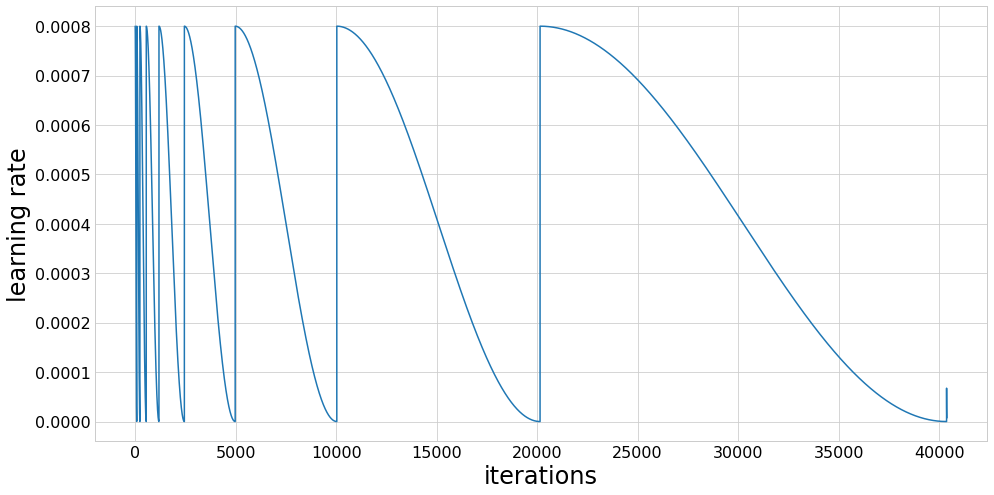

Fold took 674.668s

Training model 8 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.951550). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.476397). Check your callbacks.
  % delta_t_median)


1 New best found: 4.2813621851885427e-05
2 New best found: 3.702758880956229e-05
3 New best found: 3.63488459900883e-05
4 New best found: 3.5404976739464755e-05
5 New best found: 3.456680348164642e-05
6 New best found: 3.4182649655156824e-05
9 New best found: 3.3503004511250105e-05
10 New best found: 3.333700246902708e-05
12 New best found: 3.320588816860218e-05
13 New best found: 3.300178314113059e-05
14 New best found: 3.2998581368515935e-05
15 New best found: 3.295926844634322e-05
19 New best found: 3.291691599697011e-05
22 New best found: 3.2635140451038754e-05
27 New best found: 3.251138360339187e-05
41 New best found: 3.23552809511796e-05
45 New best found: 3.231245913705348e-05
50 New best found: 3.224725014090353e-05
55 New best found: 3.223344567315148e-05
57 New best found: 3.2229380436663e-05
58 New best found: 3.2214578733232934e-05
60 New best found: 3.2194947832590406e-05
61 New best found: 3.219412762244551e-05
62 New best found: 3.219251716813932e-05
89 New best found: 

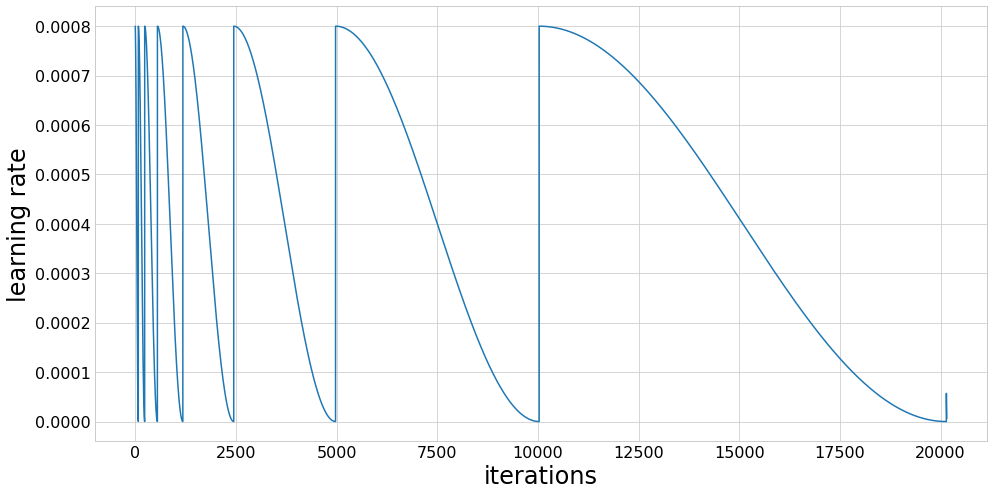

Fold took 350.842s

Training model 9 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (1.052780). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.526940). Check your callbacks.
  % delta_t_median)


1 New best found: 4.129147052881308e-05
2 New best found: 3.601453119335929e-05
3 New best found: 3.555270275392104e-05
4 New best found: 3.483139507443411e-05
5 New best found: 3.381299897591816e-05
6 New best found: 3.3491662838787304e-05
7 New best found: 3.3424754919542464e-05
9 New best found: 3.3117465615214314e-05
10 New best found: 3.28364314569626e-05
11 New best found: 3.275720640522195e-05
12 New best found: 3.245056146697607e-05
13 New best found: 3.2353111525299026e-05
14 New best found: 3.231840262451442e-05
15 New best found: 3.231543075671652e-05
20 New best found: 3.216148870706092e-05
22 New best found: 3.194797060277779e-05
23 New best found: 3.172930291766534e-05
27 New best found: 3.1697124204947615e-05
30 New best found: 3.169487513514468e-05
41 New best found: 3.1669491229695265e-05
42 New best found: 3.164129869401222e-05
43 New best found: 3.155642201600131e-05
45 New best found: 3.155584737251047e-05
49 New best found: 3.143837843235815e-05
50 New best found: 

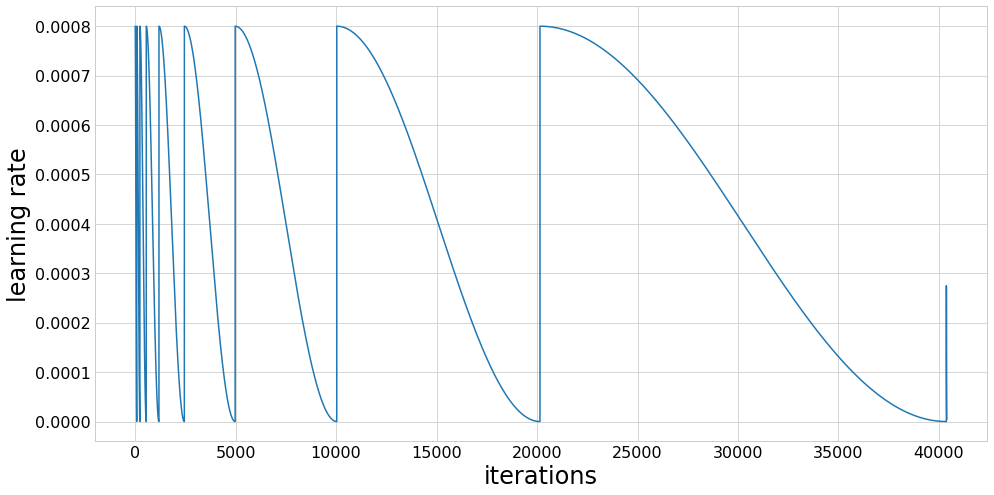

Fold took 696.479s

Training model 10 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.991993). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.496596). Check your callbacks.
  % delta_t_median)


1 New best found: 4.162536033109063e-05
2 New best found: 3.7174532243807337e-05
3 New best found: 3.636140594899189e-05
4 New best found: 3.5909199106390586e-05
5 New best found: 3.4669609005504754e-05
6 New best found: 3.432450279942714e-05
7 New best found: 3.422672216838691e-05
9 New best found: 3.40176075391355e-05
10 New best found: 3.378729797550477e-05
11 New best found: 3.320268777897581e-05
13 New best found: 3.301007594127441e-05
14 New best found: 3.2997313015221154e-05
15 New best found: 3.2981679700606035e-05
20 New best found: 3.270237253891537e-05
21 New best found: 3.2626023232296575e-05
23 New best found: 3.2601331469777504e-05
25 New best found: 3.245323026931146e-05
28 New best found: 3.2410071384219915e-05
29 New best found: 3.239047338720411e-05
30 New best found: 3.237826031836448e-05
31 New best found: 3.2372094338643364e-05
37 New best found: 3.233890323463129e-05
39 New best found: 3.2321088181925e-05
44 New best found: 3.228047773591243e-05
45 New best found:

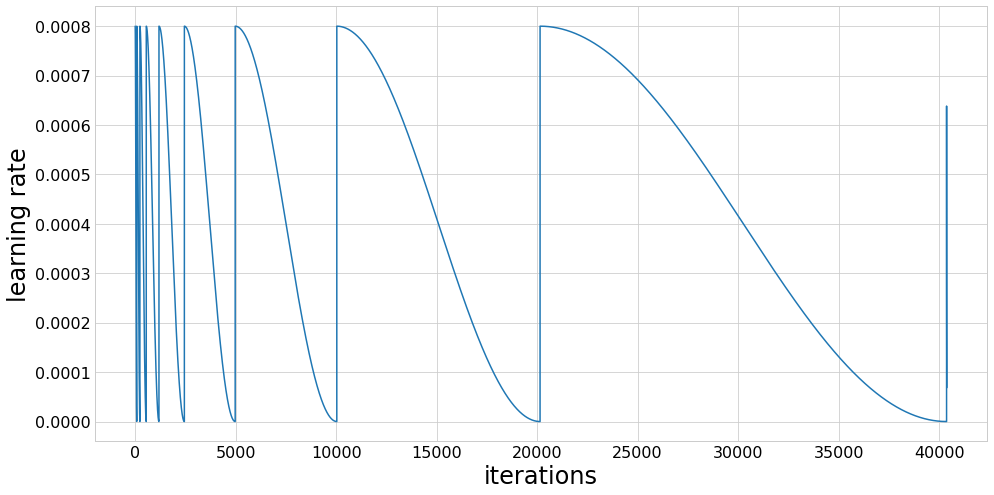

Fold took 695.134s


______________________________________
Training finished
Cross-validation took 4461.253s 


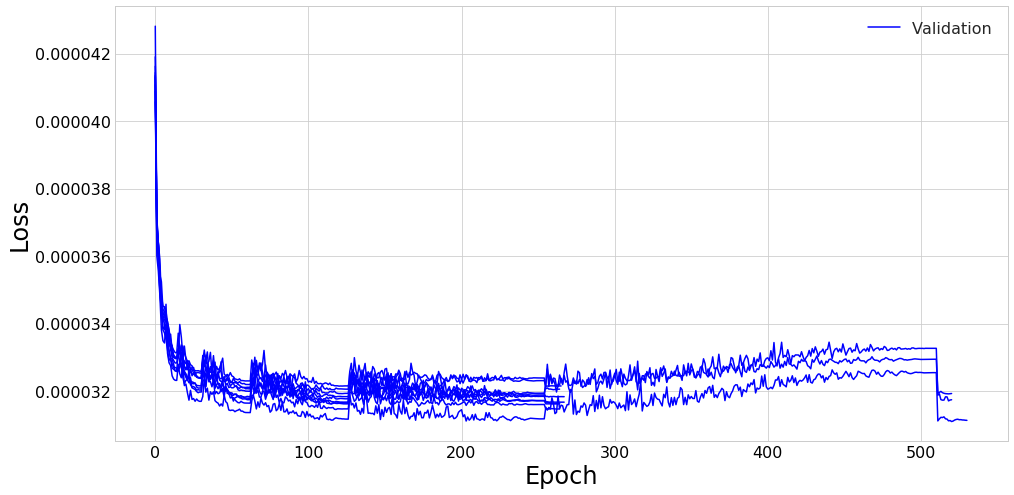

Mean loss = 3.171e-05 +- 9e-08
Mean wAUC = 0.063 +- 0.0004
Mean AUC = 0.0983 +- 0.0007
Mean AMS = 3.88 +- 0.08
Mean cut = 0.954 +- 0.006
______________________________________



<Figure size 432x288 with 0 Axes>

In [19]:
results, histories = fold_train_model(train_fy, n_models,
                                      model_gen_params=model_gen_params,
                                      train_params=train_params, train_on_weights=True,
                                      use_callbacks=use_callbacks, ams_args=ams_args,
                                      max_epochs=max_epochs, patience=patience,
                                      verbose=1, plots=plots)

## Construct ensemble

In [20]:
with open('train_weights/resultsFile.pkl', 'rb') as fin:   
    results = pickle.load(fin)

In [21]:
ensemble, weights = assemble_ensemble(results, ensemble_size, ensemble_mode, compile_args)

Choosing ensemble by loss
Model 0 is 8 with loss = 3.109618511371082e-05
Model 1 is 5 with loss = 3.145368893165141e-05
Model 2 is 4 with loss = 3.1618098363796927e-05
Model 3 is 3 with loss = 3.161922785787697e-05
Model 4 is 0 with loss = 3.166829367670638e-05
Model 5 is 9 with loss = 3.1707881900365465e-05
Model 6 is 1 with loss = 3.182536574167898e-05
Model 7 is 6 with loss = 3.190863901525626e-05
Model 8 is 7 with loss = 3.2037886821903616e-05
Model 9 is 2 with loss = 3.214432058128995e-05


## Response on validation data without TTA

In [22]:
val_fy = FoldYielder(h5py.File(DATA_PATH/'val.hdf5', "r+"))

In [23]:
fold_ensemble_predict(ensemble, weights, val_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.003220042622089386s per sample

Predicting fold 2 out of 10
Prediction took 0.000451206174492836s per sample

Predicting fold 3 out of 10
Prediction took 0.0004450399003922939s per sample

Predicting fold 4 out of 10
Prediction took 0.0004222539983689785s per sample

Predicting fold 5 out of 10
Prediction took 0.0004377377577126026s per sample

Predicting fold 6 out of 10
Prediction took 0.0004414202369749546s per sample

Predicting fold 7 out of 10
Prediction took 0.00044060370922088625s per sample

Predicting fold 8 out of 10
Prediction took 0.0004513197854161262s per sample

Predicting fold 9 out of 10
Prediction took 0.0004461083948612213s per sample

Predicting fold 10 out of 10
Prediction took 0.000445836678147316s per sample



In [24]:
val_df = convert_to_df(val_fy.source)

50000 candidates loaded


In [25]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(val_df.gen_target, val_df.pred_class),
                                                           roc_auc_score(val_df.gen_target, val_df.pred_class, sample_weight=val_df.gen_weight)))

Testing ROC AUC: unweighted 0.9041128959272413, weighted 0.9360986122655541


Mean cut at 0.95621425 corresponds to AMS of 3.7833207499056907
Maximum AMS for data is 3.954850963569008 at cut of 0.96288001537323
CPU times: user 103 ms, sys: 0 ns, total: 103 ms
Wall time: 102 ms


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


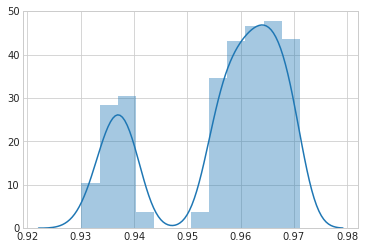

In [27]:
%%time
cut_mean = mean_optimise_cut(val_df, top_perc=0.05, br=10, w_factor=250000/50000)

# Test scoring - Without TTA

In [28]:
test_fy = FoldYielder(h5py.File(DATA_PATH/'testing.hdf5', "r+"))

In [29]:
%%time
fold_ensemble_predict(ensemble, weights, test_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.0004452791299332272s per sample

Predicting fold 2 out of 10
Prediction took 0.00045112289705059747s per sample

Predicting fold 3 out of 10
Prediction took 0.0004541031356562268s per sample

Predicting fold 4 out of 10
Prediction took 0.0004521970515901392s per sample

Predicting fold 5 out of 10
Prediction took 0.0004476735405623913s per sample

Predicting fold 6 out of 10
Prediction took 0.0004481832782653245s per sample

Predicting fold 7 out of 10
Prediction took 0.00044636778540231966s per sample

Predicting fold 8 out of 10
Prediction took 0.00045620987198569557s per sample

Predicting fold 9 out of 10
Prediction took 0.00044702062850648705s per sample

Predicting fold 10 out of 10
Prediction took 0.0004477095862681215s per sample

CPU times: user 4min 22s, sys: 16.6 s, total: 4min 38s
Wall time: 4min 7s


In [30]:
score_test_data(test_fy.source, cut_kde)

Public:Private AMS: 3.6216305412447776 : 3.722040611435642


(3.6216305412447776, 3.722040611435642)

In [31]:
score_test_data(test_fy.source, cut_mean)

Public:Private AMS: 3.709060805209783 : 3.7400552027001646


(3.709060805209783, 3.7400552027001646)

# Save/Load

In [ ]:
name = "weights/Swish_CLR_TTA"

In [ ]:
saveEnsemble(name, ensemble, weights, compile_args, overwrite=1)

In [ ]:
ensemble, weights, compile_args, _, _ = loadEnsemble(name)